In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import cv2
import numpy as np
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
POS_PATH = os.path.join('/content/drive/MyDrive/data', 'positive')
NEG_PATH = os.path.join('/content/drive/MyDrive/data', 'negative')
ANC_PATH = os.path.join('/content/drive/MyDrive/data', 'anchor')

In [4]:
POS_PATH

'/content/drive/MyDrive/data/positive'

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]

    # Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)

    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)

    # Show image back to screen
    cv2.imshow('Image Collection', frame)

    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [5]:
import uuid

In [6]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))

        data.append(img)

    return data

In [ ]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img)

    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [ ]:
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img)

    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())


In [7]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(3000)

In [8]:
dir_test = anchor.as_numpy_iterator()

In [9]:
print(dir_test.next())

b'/content/drive/MyDrive/data/anchor/8f02ed58-436b-11ee-bde9-84a93843152d.jpg'


In [10]:
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
#     print(byte_img)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)
#     print(img)
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0

    # Return image
    return img

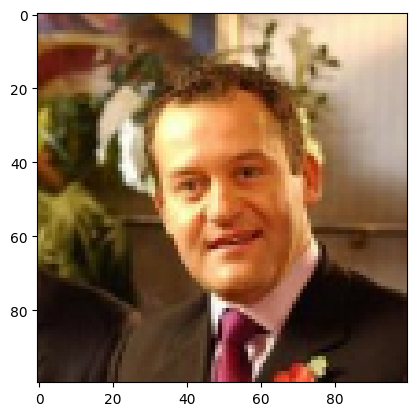

In [68]:
neg_iter = negative.as_numpy_iterator()
neg_img = preprocess(neg_iter.next())
plt.imshow(neg_img)

In [11]:
img = preprocess('/content/drive/MyDrive/data/anchor/d37525e4-4316-11ee-941f-84a93843152d.jpg')
img

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.7531863 , 0.70612746, 0.6120098 ],
        [0.7470588 , 0.7019608 , 0.60490197],
        [0.7411765 , 0.7019608 , 0.59607846],
        ...,
        [0.50735295, 0.5085784 , 0.42843136],
        [0.49362746, 0.50539213, 0.42303923],
        [0.49411765, 0.5137255 , 0.42745098]],

       [[0.7492647 , 0.7080882 , 0.60906863],
        [0.74607843, 0.70490193, 0.6       ],
        [0.74240196, 0.7019608 , 0.5955882 ],
        ...,
        [0.5122549 , 0.50514704, 0.42132354],
        [0.49583334, 0.5007353 , 0.41911766],
        [0.48921567, 0.4990196 , 0.41960785]],

       [[0.74607843, 0.70490193, 0.6       ],
        [0.7497549 , 0.7078431 , 0.6022059 ],
        [0.7490196 , 0.7056373 , 0.59632355],
        ...,
        [0.5154412 , 0.49362746, 0.39485294],
        [0.50980395, 0.49313724, 0.4122549 ],
        [0.49289215, 0.485049  , 0.4107843 ]],

       ...,

       [[0.2627451 , 0.2784314 , 0.3254902 ],
        [0.27

In [12]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [13]:
samples = data.as_numpy_iterator()

In [14]:
example = samples.next()

In [15]:
example

(b'/content/drive/MyDrive/data/anchor/8498f9e5-436b-11ee-9ea2-84a93843152d.jpg',
 b'/content/drive/MyDrive/data/positive/2e51dd03-4317-11ee-8308-84a93843152d.jpg',
 1.0)

In [16]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [17]:
res = preprocess_twin(*example)

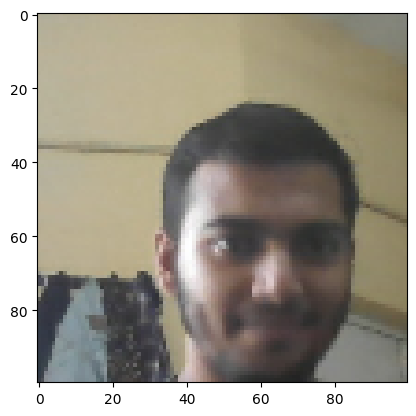

In [18]:
plt.imshow(res[1])

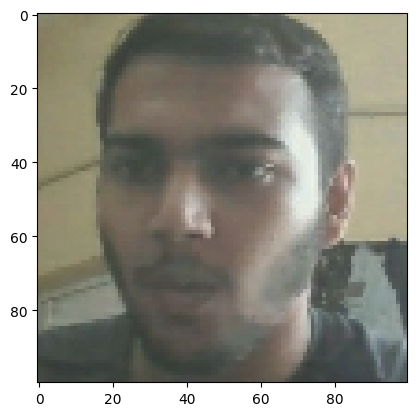

In [19]:
plt.imshow(res[0])

In [20]:
res[2]

1.0

In [21]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [22]:
sam = data.as_numpy_iterator()

In [27]:
sam.next()

(array([[[0.66544116, 0.657598  , 0.6066176 ],
         [0.67058825, 0.6627451 , 0.6039216 ],
         [0.6742647 , 0.6664216 , 0.60759807],
         ...,
         [0.50980395, 0.54509807, 0.47058824],
         [0.5058824 , 0.5411765 , 0.46666667],
         [0.50784314, 0.54313725, 0.46862745]],
 
        [[0.67941177, 0.67156863, 0.6127451 ],
         [0.67156863, 0.6666667 , 0.60637254],
         [0.6625    , 0.6642157 , 0.6002451 ],
         ...,
         [0.50980395, 0.5382353 , 0.45490196],
         [0.5009804 , 0.5294118 , 0.44607842],
         [0.5009804 , 0.5294118 , 0.4480392 ]],
 
        [[0.6786765 , 0.6737745 , 0.60612744],
         [0.6634804 , 0.66740197, 0.5982843 ],
         [0.6617647 , 0.66568625, 0.595098  ],
         ...,
         [0.5085784 , 0.5232843 , 0.43504903],
         [0.5095588 , 0.5203431 , 0.43406862],
         [0.5117647 , 0.52181375, 0.44117647]],
 
        ...,
 
        [[0.40980393, 0.45686275, 0.44117647],
         [0.44093138, 0.4879902 , 0.47377

In [24]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [25]:
len(train_data)

263

In [26]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [28]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [29]:
embedding = make_embedding()

In [30]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [31]:
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    #similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [32]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    model = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

    return model

In [33]:
siamese_model = make_siamese_model()

In [34]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [35]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [36]:
opt = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/Siamese_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [37]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    # print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

In [38]:
from tensorflow.keras.metrics import Precision, Recall

In [39]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Creating a metric object
        r = Recall()
        p = Precision()

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())

        # Save checkpoints
        # if epoch % 10 == 0:
        #     checkpoint.save(file_prefix=checkpoint_prefix)

In [40]:
EPOCHS = 10
train(train_data, EPOCHS)


 Epoch 1/10
263/263 [==============================] - 89s 297ms/step
0.010085154 0.93213767 0.99585706

 Epoch 2/10
263/263 [==============================] - 69s 261ms/step
0.090336904 0.9855002 0.99463415

 Epoch 3/10
263/263 [==============================] - 69s 263ms/step
0.05038452 0.98544395 0.99558824

 Epoch 4/10
263/263 [==============================] - 67s 254ms/step
0.0304963 0.99712366 0.9966459

 Epoch 5/10
263/263 [==============================] - 68s 258ms/step
0.06414649 0.99577266 0.9962406

 Epoch 6/10
263/263 [==============================] - 67s 256ms/step
0.060842548 0.9961594 0.998076

 Epoch 7/10
263/263 [==============================] - 66s 252ms/step
0.003872297 0.9956626 0.99903286

 Epoch 8/10
263/263 [==============================] - 66s 249ms/step
0.04655931 0.99952245 0.9985687

 Epoch 9/10
263/263 [==============================] - 67s 254ms/step
0.0067582782 0.9971738 0.9929643

 Epoch 10/10
263/263 [==============================] - 66s 249ms/st

In [ ]:
siamese_model.save('/content/drive/MyDrive/Colab Notebooks/siamese_modelv2.h5')

In [41]:
from tensorflow.keras.metrics import Precision, Recall

In [42]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [44]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 35ms/step


In [45]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0]

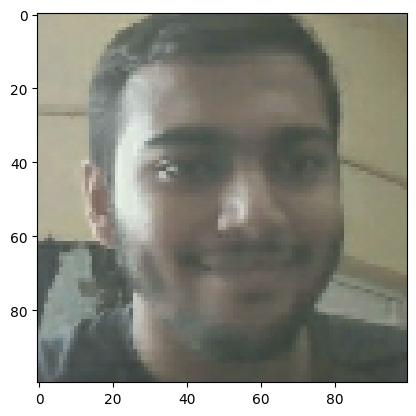

In [50]:
myanc = preprocess('/content/drive/MyDrive/data/anchor/8166d885-436b-11ee-b341-84a93843152d.jpg')
plt.imshow(myanc)

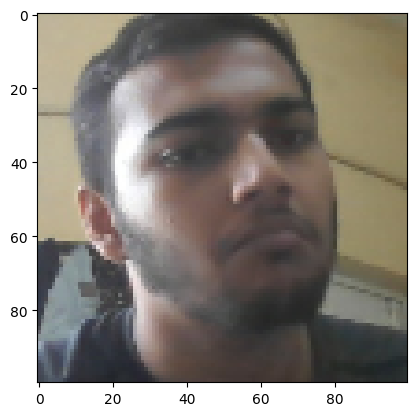

In [51]:
pic = preprocess(dir_test.next())
plt.imshow(pic)


In [58]:
pic_arr = np.array(pic)
pic_arr = pic_arr.reshape(1,100,100,3)

In [54]:
myanc_arr = np.array(myanc)

In [55]:
myanc_arr = myanc_arr.reshape(1,100,100,3)

In [62]:
pic_predict = siamese_model.predict([pic_arr, myanc_arr])
pic_predict

1/1 [==============================] - 0s 40ms/step


array([[0.9858737]], dtype=float32)

In [65]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    # print(yhat)
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat)

print(f"Recall: {r.result().numpy()}, Precision: {p.result().numpy()}")

1/1 [==============================] - 0s 25ms/step
Recall: 0.9989047050476074, Precision: 0.9967213273048401
